# Lab 02: Softmax Regression

## 1. Import Libraries

In [181]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

## 2. Load **Dataset MNIST** 

Directly from *tensorflow.keras.datasets* library

In [182]:
from tensorflow.keras.datasets import mnist

In [183]:
def load_mnist(flatten=True, normalize=True):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype(np.float32)
    x_test  = x_test.astype(np.float32)

    return x_train, y_train, x_test, y_test

## 3. Pre-Processing

In [184]:
x_train_raw, y_train_raw, x_test_raw, y_test_raw = load_mnist()
X_all = np.concatenate([x_train_raw, x_test_raw], axis=0)
y_all = np.concatenate([y_train_raw, y_test_raw], axis=0)

### 3.1 Thống kê cơ bản (Basic statistics)

*Number of samples, image dimensions, min/max, mean, std*

In [185]:
print("Number of samples:", X_all.shape[0])
print("Image shape:", X_all.shape[1:])
print("Pixel range:", X_all.min(), "-", X_all.max())
print("Mean pixel value:", X_all.mean())
print("Std of pixel values:", X_all.std())

Number of samples: 70000
Image shape: (28, 28)
Pixel range: 0.0 - 255.0
Mean pixel value: 33.38596
Std of pixel values: 78.654396
Std of pixel values: 78.654396


*Check for NaN, Inf*

In [186]:
print("Has NaN:", np.isnan(X_all).any())
print("Has Inf:", np.isinf(X_all).any())

Has NaN: False
Has Inf: False


### Label distribution

In [187]:
unique, counts = np.unique(y_all, return_counts=True)
total_samples = y_all.shape[0]

print(f"{'Label':<10} {'Count':<10} {'Percentage':<15}")
print("-" * 35)
for label, count in zip(unique, counts):
    percent = (count / total_samples) * 100
    print(f"{label:<10} {count:<10} {percent:.2f}%")

Label      Count      Percentage     
-----------------------------------
0          6903       9.86%
1          7877       11.25%
2          6990       9.99%
3          7141       10.20%
4          6824       9.75%
5          6313       9.02%
6          6876       9.82%
7          7293       10.42%
8          6825       9.75%
9          6958       9.94%


==> Data is quite balanced, we will use a Barplot to visualize it better

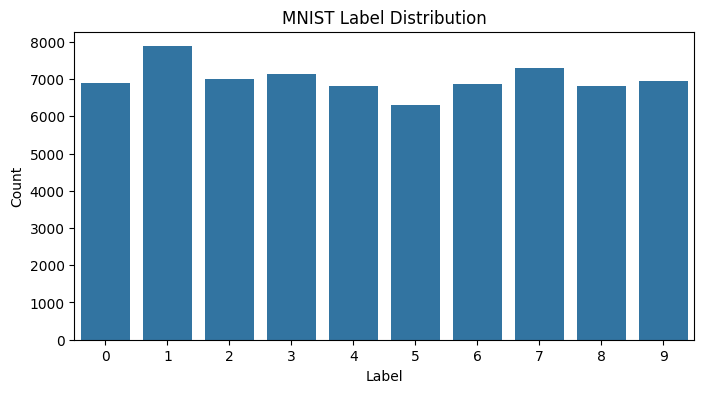

In [188]:
plt.figure(figsize=(8,4))
sns.countplot(x=y_all)
plt.title("MNIST Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Data Observation

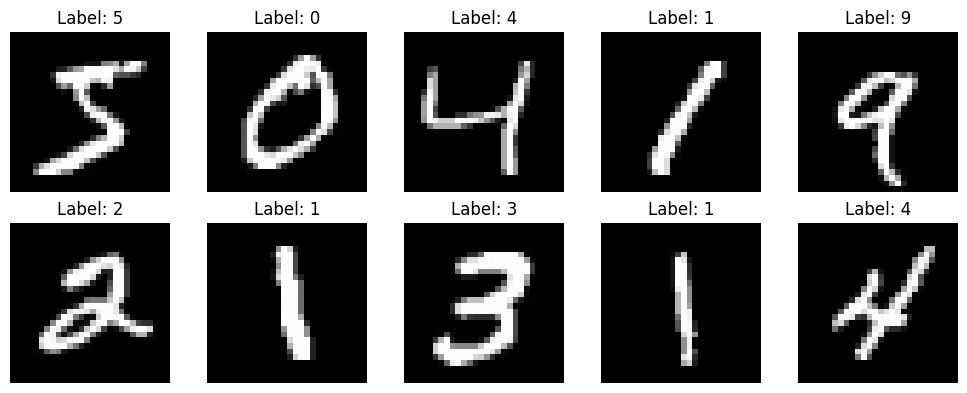

In [189]:
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_all[i], cmap='gray')
    plt.title(f"Label: {y_all[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Mean pixel statistics per class (Mean image per class)

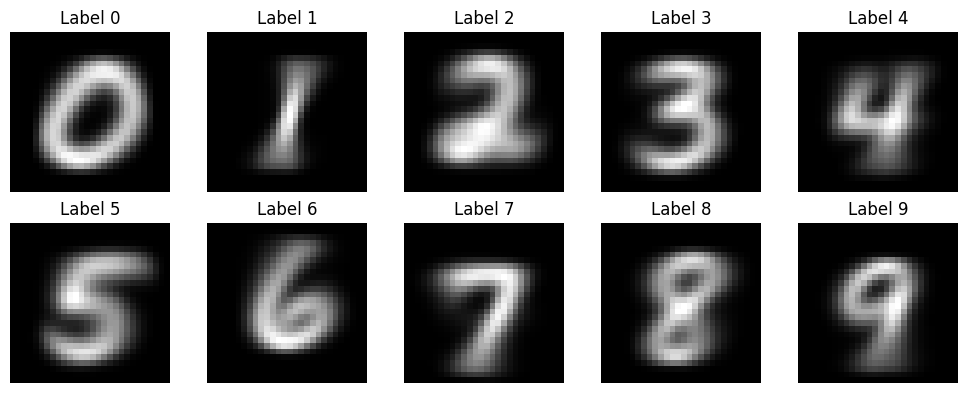

In [190]:
mean_images = []
for label in np.unique(y_all):
    mean_img = X_all[y_all == label].mean(axis=0)
    mean_images.append(mean_img)

plt.figure(figsize=(10,4))
for i, img in enumerate(mean_images):
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Histogram pixel (Pixel intensity distribution)

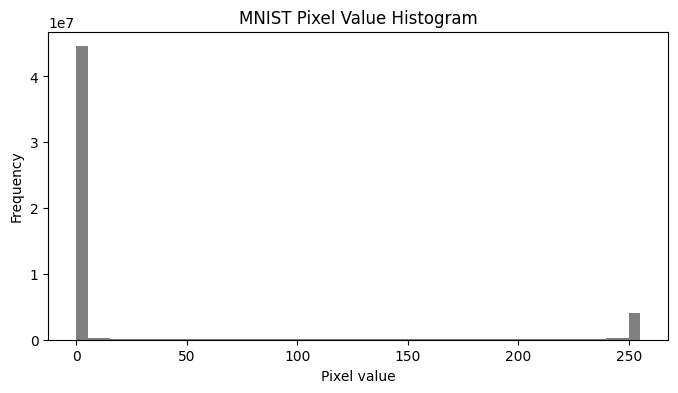

In [191]:
plt.figure(figsize=(8,4))
plt.hist(X_all.ravel(), bins=50, color='gray')
plt.title("MNIST Pixel Value Histogram")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

### Correlation heatmap (Of first 1000 images)

d:\HCMUS\HK8\ML Introduction\lab\lab2\INTROML\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\HCMUS\HK8\ML Introduction\lab\lab2\INTROML\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


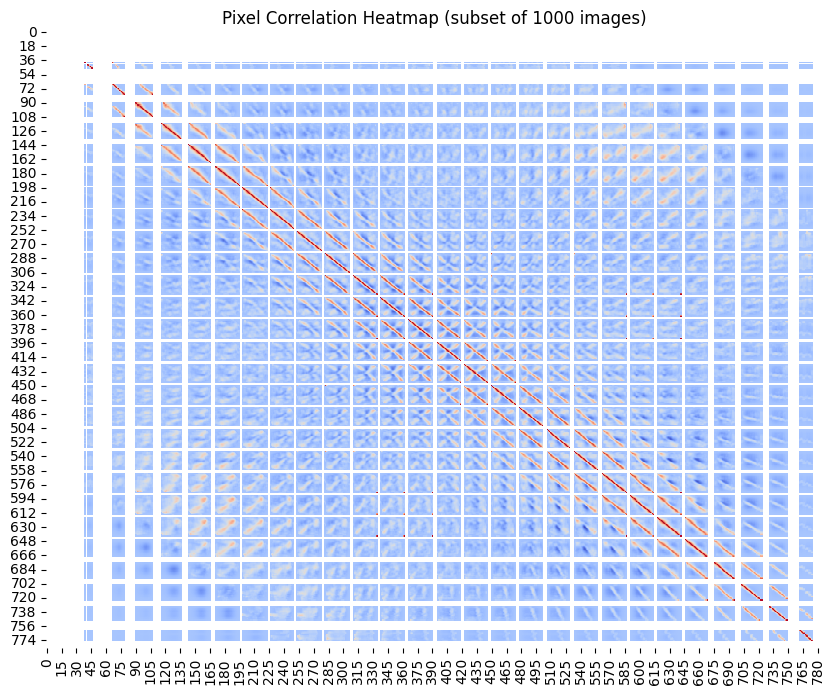

In [192]:
subset = X_all[:1000].reshape(1000, -1)
corr = np.corrcoef(subset.T)  # pixel correlation
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', cbar=False)
plt.title("Pixel Correlation Heatmap (subset of 1000 images)")
plt.show()

## 4. Image Feature Extraction

During the model training process, three groups of image features were constructed:

**Normalized Pixel Features**
- Normalize pixel values to \([0, 1]\).
- Flatten the image into a feature vector.

**Edge-based Features**
- Evaluate two edge detection filters:
  - **Canny edge detector**
  - **Sobel operator** (used as the default)
- These features highlight contours and digit shapes.

**Block Averaging Features**
- Divide the image into small blocks.
- Compute the average value of each block to reduce dimensionality while preserving the overall structure of the image.


### 4.1 Normalized

In [193]:
def normalized_pixels(X):
    return X / 255.0 

### 4.2 Edge Normalization
Using both Sobel and Canny

In [194]:
def sobel_edge_features(X):
    
    # 1. Calculate edges
    edges = np.array([
        np.sqrt(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)**2 + 
                cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)**2)
        for img in X
    ], dtype=np.float32)
    
    # 2. Normalize edges to 0-1
    edges = np.array([e / (e.max() + 1e-8) for e in edges], dtype=np.float32)
    
    return edges

def canny_edge_features(X):
    # 1. Canny requires uint8 input (0-255)
    if X.dtype != np.uint8:
        X_uint8 = X.astype(np.uint8)
    else:
        X_uint8 = X

    # 2. Apply Canny to each image in batch
    edges = np.array([cv2.Canny(img, 100, 200) for img in X_uint8], dtype=np.float32)
    
    edges = np.array([e / 255.0 for e in edges], dtype=np.float32)

    return edges

### 4.3 Block Averaging

In [195]:
def block_averaging(X, block_size=2):
    # 1. Handle flexible input (int or tuple)
    if isinstance(block_size, int):
        bh = bw = block_size
    else:
        bh, bw = block_size
        
    N, H, W = X.shape
    print(N, H, W)

    # 2. Calculate new size (ignore remainder if image is not divisible)
    new_h = H // bh
    new_w = W // bw
    
    # Actual size to be used for cropping
    valid_h = new_h * bh
    valid_w = new_w * bw

    # 3. Crop image to ensure divisibility by block_size
    X_cropped = X[:, :valid_h, :valid_w]

    # 4. Reshape to 5D grid
    blocked = X_cropped.reshape(N, new_h, bh, new_w, bw)

    # 5. CALCULATE MEAN
    return blocked.mean(axis=(2, 4))

## 5. Feature Vector Designs

### 5.1 Visualization function

In [196]:
def visualize_universal(idx, X_origin, X_processed):
    # Get feature vector of image at index idx
    feature_vector = X_processed[idx]
    vector_len = feature_vector.shape[0] # e.g. 784 or 1568
    
    img_origin = X_origin[idx]
    
    plt.figure(figsize=(10, 4))
    
    # --- CASE 1: DESIGN 1 (Only 784 features) ---
    if vector_len == 784:
        # Reshape to 28x28
        img_reconstructed = feature_vector.reshape(28, 28)
        
        plt.subplot(1, 2, 1); plt.imshow(img_origin, cmap='gray'); plt.title("Original Image (28x28)")
        plt.subplot(1, 2, 2); plt.imshow(img_reconstructed, cmap='gray'); plt.title("Normalized (28x28)")

    # --- CASE 2: DESIGN 2 (1568 features - With Sobel/Canny) ---
    elif vector_len == 1568:
        # Reshape to 28x28x2
        img_reconstructed = feature_vector.reshape(28, 28, 2)
        
        # Separate channels
        ch_edges    = img_reconstructed[:, :, 1]
        
        plt.subplot(1, 2, 1); plt.imshow(img_origin, cmap='gray'); plt.title("Original Image (28x28)")
        plt.subplot(1, 2, 2); plt.imshow(ch_edges, cmap='gray'); plt.title("Edges (28x28)")

    # --- CASE 3: DESIGN 3 Block Averaging (Size 196) ---
    elif vector_len == 196: # 14x14 = 196
        img_reconstructed = feature_vector.reshape(14, 14)
        
        plt.subplot(1, 2, 1)
        plt.imshow(img_origin, cmap='gray')
        plt.title("Original Image (28x28)")
        
        plt.subplot(1, 2, 2)
        plt.imshow(img_reconstructed, cmap='gray')
        # Disable smoothing to see pixel effect clearly
        plt.title("Block Averaging (14x14)")
        
    else:
        print(f"Size {vector_len} is unusual, don't know how to visualize!")
        
    plt.tight_layout()
    plt.show()

### 5.1 Function 1

*Feature engineering*

In [197]:
def function1(x_train, y_train, x_test, y_test):

    # --- 1. PREPARE BASE IMAGE ---
    x_train_nor = normalized_pixels(x_train)
    x_test_nor  = normalized_pixels(x_test)
    
    # --- 2. FLATTEN ---
    x_new_train = x_train_nor.reshape(len(x_train_nor), -1)  # (60000, 784)
    x_new_test  = x_test_nor.reshape(len(x_test_nor), -1)    # (10000, 784)
    
    return x_new_train, y_train, x_new_test, y_test

### 5.2 Function 2


Function 2 combines normalized and edges. Output is a 1D array. All images are merged compared to the original image

In [198]:
def function2(x_train, y_train, x_test, y_test, method='sobel'):
    # --- 1. PREPARE BASE IMAGE ---
    x_train_nor = normalized_pixels(x_train)
    x_test_nor  = normalized_pixels(x_test)

    x_train_edges = None
    x_test_edges  = None

    # --- 2. CALCULATE EDGES (FEATURE ENGINEERING) ---
    if method == 'sobel':
        x_train_edges = sobel_edge_features(x_train_nor) 
        x_test_edges  = sobel_edge_features(x_test_nor)

    elif method == 'canny':
        x_train_edges = canny_edge_features(x_train)
        x_test_edges  = canny_edge_features(x_test)

    # --- 3. STACK/MERGE ---
    if x_train_edges is not None:
        X_new_train = np.stack([x_train_nor, x_train_edges], axis=-1)
        X_new_test  = np.stack([x_test_nor, x_test_edges], axis=-1)
    else:
        X_new_train = x_train_nor[..., np.newaxis]
        X_new_test  = x_test_nor[..., np.newaxis]

    # --- 4. FLATTEN ---
    x_new_train = X_new_train.reshape(X_new_train.shape[0], -1)
    x_new_test  = X_new_test.reshape(X_new_test.shape[0], -1)
    
    # --- 5. COMPARE WITH NEW IMAGE ---
    visualize_universal(0, x_train, x_new_train)
    
    return x_new_train, y_train, x_new_test, y_test

### 5.3 Function 3

*Feature engineering*

In [199]:
# block averaging
def function3(x_train, y_train, x_test, y_test):
    
     # --- 1. PREPARE BASE IMAGE ---
    x_train_nor = normalized_pixels(x_train)
    x_test_nor  = normalized_pixels(x_test)

    # --- 2. BLOCK AVERAGING ---
    x_train_avg = block_averaging(x_train_nor)
    x_test_avg = block_averaging(x_test_nor)

    # --- 3. FLATTEN ---
    x_new_train = x_train_avg.reshape(len(x_train_avg), -1)
    x_new_test = x_test_avg.reshape(len(x_test_avg), -1)
    
    # --- 4. COMPARE WITH NEW IMAGE ---
    visualize_universal(0, x_train, x_new_train)
    
    return x_new_train, y_train, x_new_test, y_test

## 6. Model Implementation

### SoftmaxRegression includes:
- `__init__`: Initialize parameters, weights, bias, history
- `_softmax`: Softmax function
- `_one_hot`: Convert labels to one-hot
- `_compute_accuracy`: Calculate accuracy
- `_cross_entropy_loss`: Calculate cross-entropy loss
- `fit`: Train the model
- `predict`: Predict labels
- `predict_proba`: Predict probabilities
- `evaluate`: Evaluate the model


In [200]:
class SoftmaxRegression:
    def __init__(self, num_classes=10, lr=0.1, num_epochs=2000, batch_size=128):
        self.num_classes = num_classes
        self.lr = lr
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.W = None
        self.b = None
        self.history = {
            'loss': [],
            'train_acc': [],
            'val_acc': []
        }
    def _softmax(self, z):
        z_stable = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_stable)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _one_hot(self, y):
        N = y.shape[0]
        y_oh = np.zeros((N, self.num_classes))
        y_oh[np.arange(N), y] = 1
        return y_oh
    
    def _compute_accuracy(self, X, y):
        probs = self._softmax(np.dot(X, self.W) + self.b)
        preds = np.argmax(probs, axis=1)
        return np.mean(preds == y)

    def _cross_entropy_loss(self, probs, y_oh):
        N = probs.shape[0]
        return -np.sum(y_oh * np.log(probs + 1e-9)) / N
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        N, D = X_train.shape

        if self.W is None:
            self.W = 0.01 * np.random.randn(D, self.num_classes).astype(np.float32)
            self.b = np.zeros((1, self.num_classes), dtype=np.float32)

        y_train_oh = self._one_hot(y_train)
        num_batches = int(np.ceil(N / self.batch_size))

        for epoch in range(self.num_epochs):
            indices = np.random.permutation(N)
            X_train_shuffled = X_train[indices]
            y_train_oh_shuffled = y_train_oh[indices]

            epoch_loss = 0

            for i in range(num_batches):
                start = i * self.batch_size
                end = min((i + 1) * self.batch_size, N)

                X_batch = X_train_shuffled[start:end]
                y_batch_oh = y_train_oh_shuffled[start:end]
                B = X_batch.shape[0]

                logits = np.dot(X_batch, self.W) + self.b
                probs = self._softmax(logits)

                batch_loss = self._cross_entropy_loss(probs, y_batch_oh)
                epoch_loss += batch_loss

                dlogits = (probs - y_batch_oh) / B
                dW = np.dot(X_batch.T, dlogits)
                db = np.sum(dlogits, axis=0, keepdims=True)

                self.W -= self.lr * dW
                self.b -= self.lr * db

            avg_loss = epoch_loss / num_batches
            train_acc = self._compute_accuracy(X_train, y_train)

            self.history['loss'].append(avg_loss)
            self.history['train_acc'].append(train_acc)

            if epoch % 10 == 0:
                msg = f"Epoch {epoch+1}/{self.num_epochs} - loss={avg_loss:.4f} - train_acc={train_acc:.4f}"

                if X_val is not None and y_val is not None:
                    val_acc = self._compute_accuracy(X_val, y_val)
                    self.history['val_acc'].append(val_acc)
                    msg += f" - val_acc={val_acc:.4f}"

                print(msg)
    def predict(self, X):
        probs = self._softmax(np.dot(X, self.W) + self.b)
        return np.argmax(probs, axis=1)

    def predict_proba(self, X):
        return self._softmax(np.dot(X, self.W) + self.b)

    def evaluate(self, X, y):
        probs = self._softmax(np.dot(X, self.W) + self.b)
        y_oh = self._one_hot(y)
        loss = self._cross_entropy_loss(probs, y_oh)
        acc = np.mean(np.argmax(probs, axis=1) == y)
        return loss, acc

## 7. Evaluation

Use the following metrics to evaluate the model: 
- Accuracy
- Precision, Recall, and F1-score
- Confusion matrix visualization

*Accuracy*

In [201]:
def compute_accuracy(y_true, y_pred):
    """Compute classification accuracy."""
    return np.mean(y_true == y_pred)

*Precision, Recall, and F1-score*

In [202]:
def compute_classification_metrics(conf_matrix):
    """Compute precision, recall, F1-score for each class."""
    num_classes = conf_matrix.shape[0]

    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)

    for i in range(num_classes):
        tp = conf_matrix[i, i]
        fp = np.sum(conf_matrix[:, i]) - tp
        fn = np.sum(conf_matrix[i, :]) - tp

        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1[i] = (
            2 * precision[i] * recall[i] / (precision[i] + recall[i])
            if (precision[i] + recall[i]) > 0
            else 0
        )

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "macro_precision": precision.mean(),
        "macro_recall": recall.mean(),
        "macro_f1": f1.mean(),
    }

*Confusion matrix*

In [203]:
def compute_confusion_matrix(y_true, y_pred, num_classes=10):
    """Compute confusion matrix manually."""
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

*Visualization*

In [204]:
def plot_confusion_matrix(conf_matrix, title="Confusion Matrix"):
    """Pretty confusion matrix using matplotlib."""
    fig, ax = plt.subplots(figsize=(10, 8))

    cax = ax.imshow(conf_matrix, cmap="Blues")
    plt.title(title, fontsize=16)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)

    # Show all ticks
    ax.set_xticks(np.arange(conf_matrix.shape[1]))
    ax.set_yticks(np.arange(conf_matrix.shape[0]))

    # Annotate each cell
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, conf_matrix[i, j],
                    ha="center", va="center",
                    color="black", fontsize=10)

    fig.colorbar(cax)
    plt.tight_layout()
    plt.show()

def plot_confusion_insights(conf_matrix):
    num_classes = conf_matrix.shape[0]
    plt.figure(figsize=(16, 24))

    for i in range(num_classes):
        plt.subplot(5, 2, i + 1)

        row = conf_matrix[i]

        # Sort predictions by count (descending)
        sorted_idx = np.argsort(row)[::-1]

        # Top 3
        top_idx = sorted_idx[:3]
        top_vals = row[top_idx]

        # Others
        other_val = np.sum(row) - np.sum(top_vals)

        # X labels & Y values
        x_labels = [str(c) for c in top_idx] + ["Others"]
        y_vals = list(top_vals) + [other_val]

        bars = plt.bar(x_labels, y_vals)

        # Add text labels on bars
        for bar, val in zip(bars, y_vals):
            plt.text(bar.get_x() + bar.get_width()/2,
                     bar.get_height() + max(row)*0.02,
                     str(val),
                     ha="center",
                     fontsize=10)

        plt.title(f"Class {i} – Prediction Distribution", fontsize=14)
        plt.xlabel("Predicted Class")
        plt.ylabel("Count")
        plt.ylim(0, max(row) * 1.25)

    plt.tight_layout()
    plt.show()


def plot_class_metrics(metrics, title="Per-Class Metrics"):
    classes = np.arange(len(metrics["precision"]))

    plt.figure(figsize=(12, 6))
    bar_width = 0.25

    plt.bar(classes - bar_width, metrics["precision"],
            width=bar_width, label="Precision")
    plt.bar(classes, metrics["recall"],
            width=bar_width, label="Recall")
    plt.bar(classes + bar_width, metrics["f1"],
            width=bar_width, label="F1-Score")

    plt.xticks(classes)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.title(title, fontsize=15)
    plt.ylim(0, 1)

    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


## 8. Main

In [205]:
X_train, y_train, X_test, y_test = load_mnist()

### 8.1 Function 1

*Set-up*

In [206]:
X_train_1, y_train_1, X_test_1, y_test_1 = function1(X_train, y_train, X_test, y_test)

print(f"Train shape: {X_train_1.shape}, Labels: {y_train_1.shape}")

Train shape: (60000, 784), Labels: (60000,)


*Train*

In [207]:
model1 = SoftmaxRegression(
    num_classes=10,
    lr=0.1,
    num_epochs=50,
    batch_size=128
)

print("\nTraining:")
model1.fit(X_train_1, y_train_1)


Training:
Epoch 1/50 - loss=0.5721 - train_acc=0.8920
Epoch 1/50 - loss=0.5721 - train_acc=0.8920
Epoch 11/50 - loss=0.2874 - train_acc=0.9207
Epoch 11/50 - loss=0.2874 - train_acc=0.9207
Epoch 21/50 - loss=0.2717 - train_acc=0.9261
Epoch 21/50 - loss=0.2717 - train_acc=0.9261
Epoch 31/50 - loss=0.2638 - train_acc=0.9277
Epoch 31/50 - loss=0.2638 - train_acc=0.9277
Epoch 41/50 - loss=0.2588 - train_acc=0.9293
Epoch 41/50 - loss=0.2588 - train_acc=0.9293


*Test*

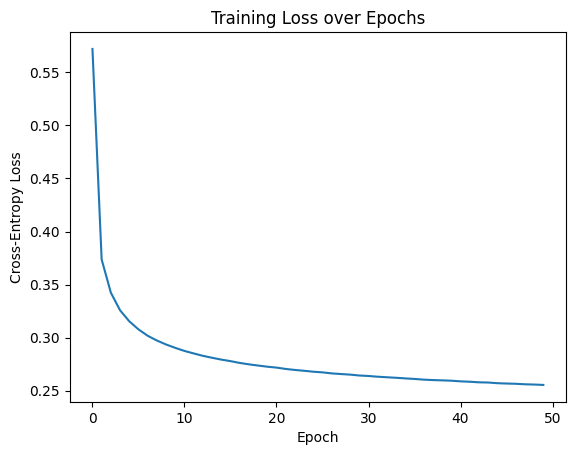

In [208]:
# Predict
predictions = model1.predict(X_test_1)

# Training loss plot
plt.plot(model1.history['loss'])
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.show()

*Visualize Test Result*

Test Accuracy: 92.57%


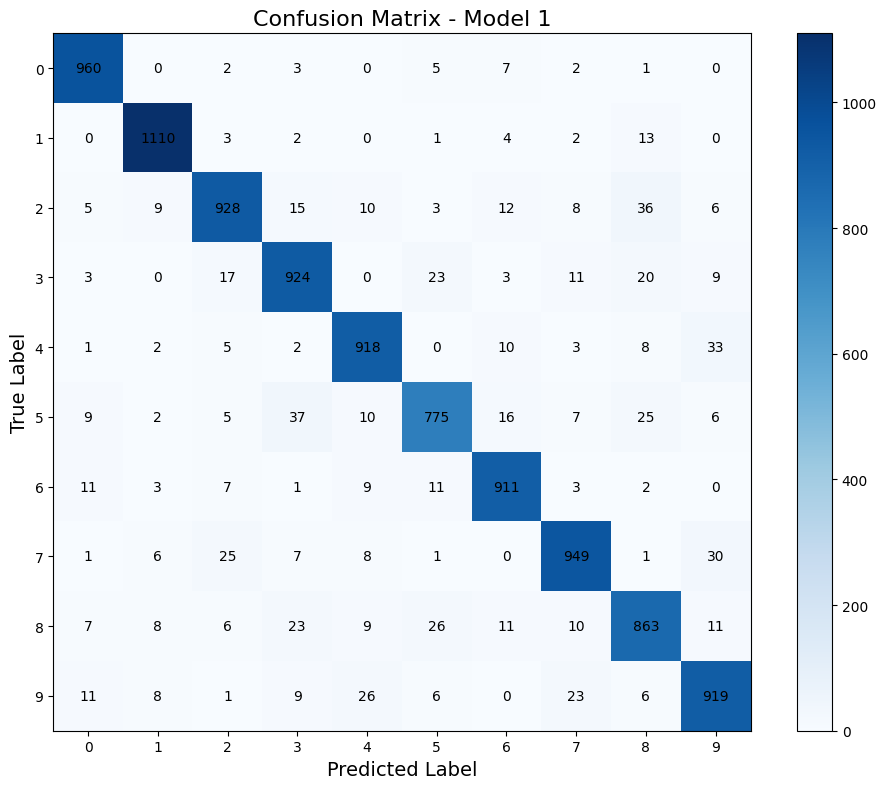

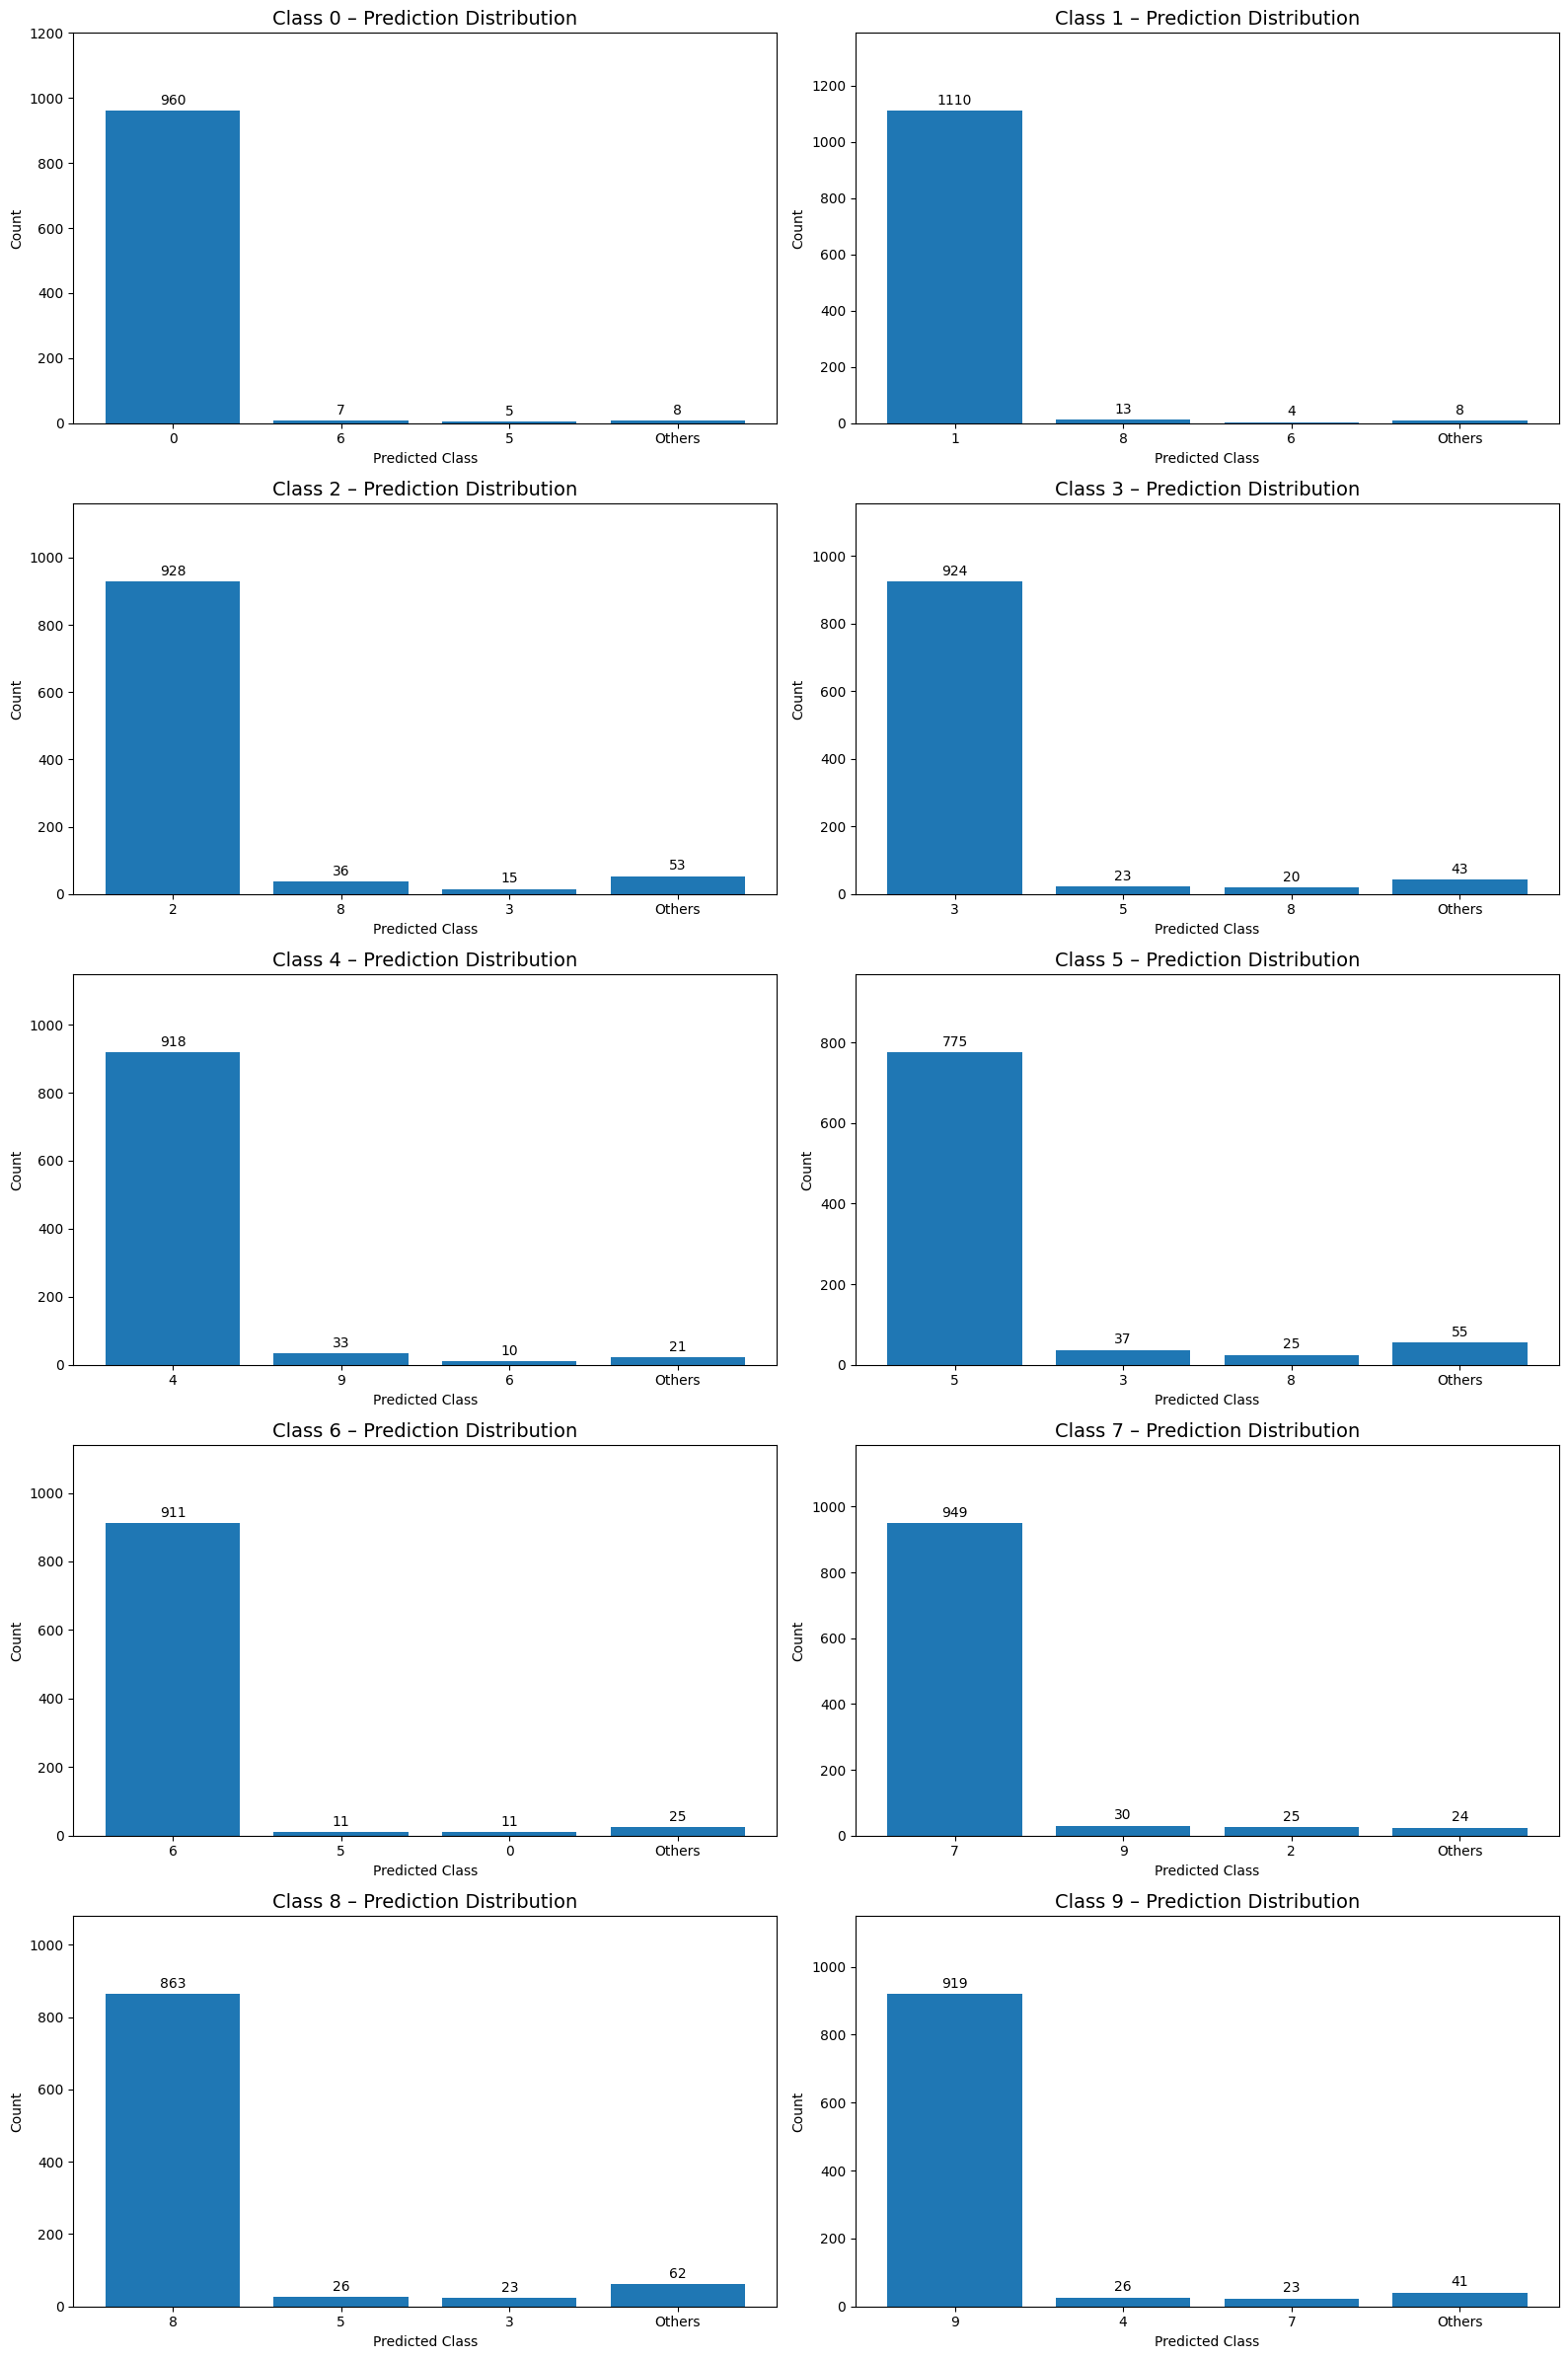

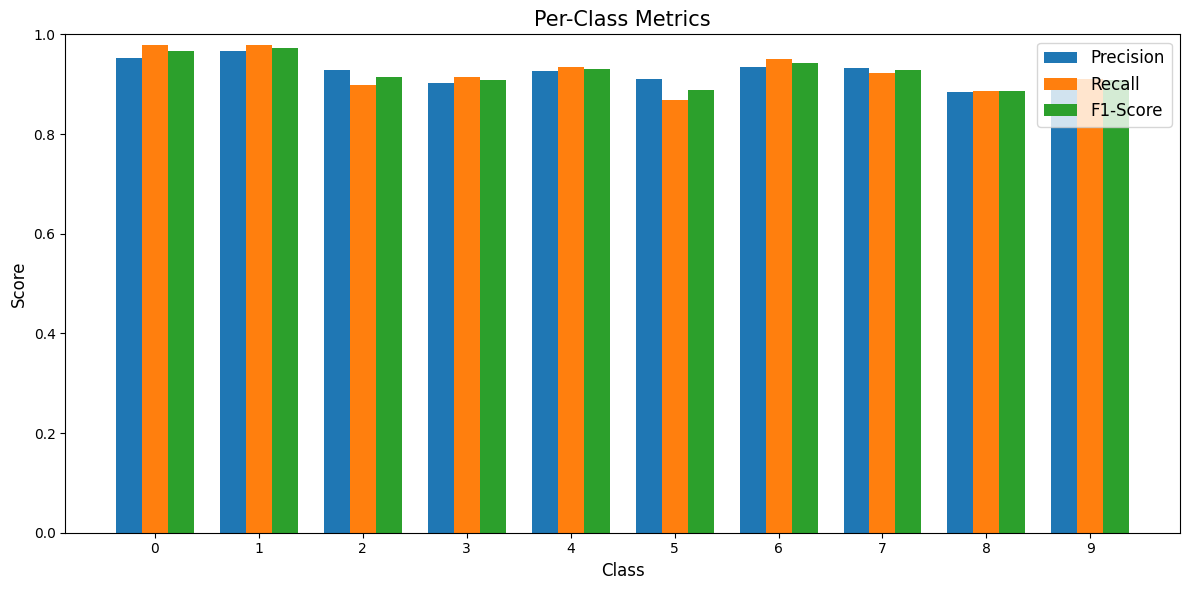

In [209]:
# Metrics
acc = compute_accuracy(y_test_1, predictions)
conf_matrix = compute_confusion_matrix(y_test_1, predictions, num_classes=10)
metrics = compute_classification_metrics(conf_matrix)

# Print accuracy
print(f"Test Accuracy: {acc * 100:.2f}%")

# Confusion matrix visualization
plot_confusion_matrix(conf_matrix, title="Confusion Matrix - Model 1")
plot_confusion_insights(conf_matrix)

# Per-class metric visualization
plot_class_metrics(metrics)


### 8.2 Edges

*Set-up*

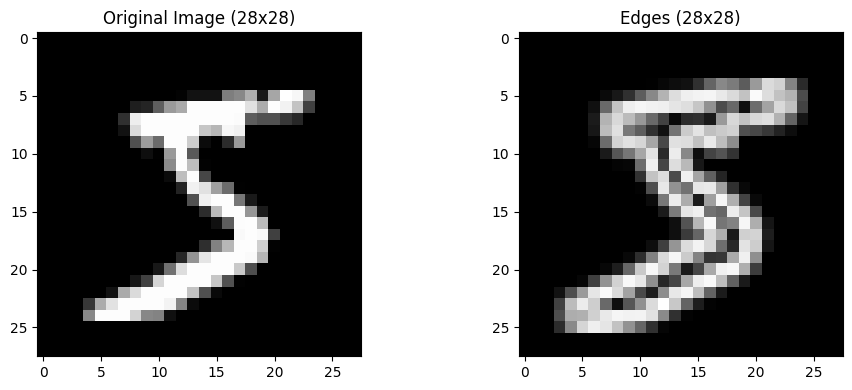

Train shape: (60000, 1568), Labels: (60000,)


In [210]:
X_train_2, y_train_2, X_test_2, y_test_2 = function2(X_train, y_train, X_test, y_test)

print(f"Train shape: {X_train_2.shape}, Labels: {y_train_2.shape}")

*Train*

In [211]:
model2 = SoftmaxRegression(
    num_classes=10,
    lr=0.1,
    num_epochs=50,
    batch_size=128
)

print("\nTraining:")
model2.fit(X_train_2, y_train_2)


Training:
Epoch 1/50 - loss=0.4727 - train_acc=0.9083
Epoch 1/50 - loss=0.4727 - train_acc=0.9083
Epoch 11/50 - loss=0.2238 - train_acc=0.9390
Epoch 11/50 - loss=0.2238 - train_acc=0.9390
Epoch 21/50 - loss=0.2019 - train_acc=0.9446
Epoch 21/50 - loss=0.2019 - train_acc=0.9446
Epoch 31/50 - loss=0.1904 - train_acc=0.9486
Epoch 31/50 - loss=0.1904 - train_acc=0.9486
Epoch 41/50 - loss=0.1821 - train_acc=0.9502
Epoch 41/50 - loss=0.1821 - train_acc=0.9502


*Test*

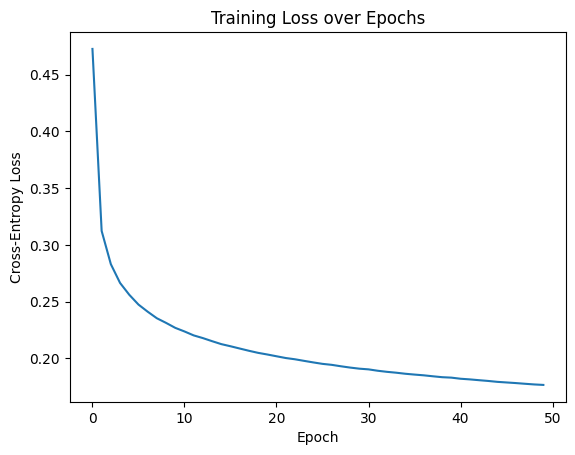

In [212]:
# Predict
predictions = model2.predict(X_test_2)

# Training loss plot
plt.plot(model2.history['loss'])
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.show()

*Visualize and report results*

Test Accuracy: 94.50%


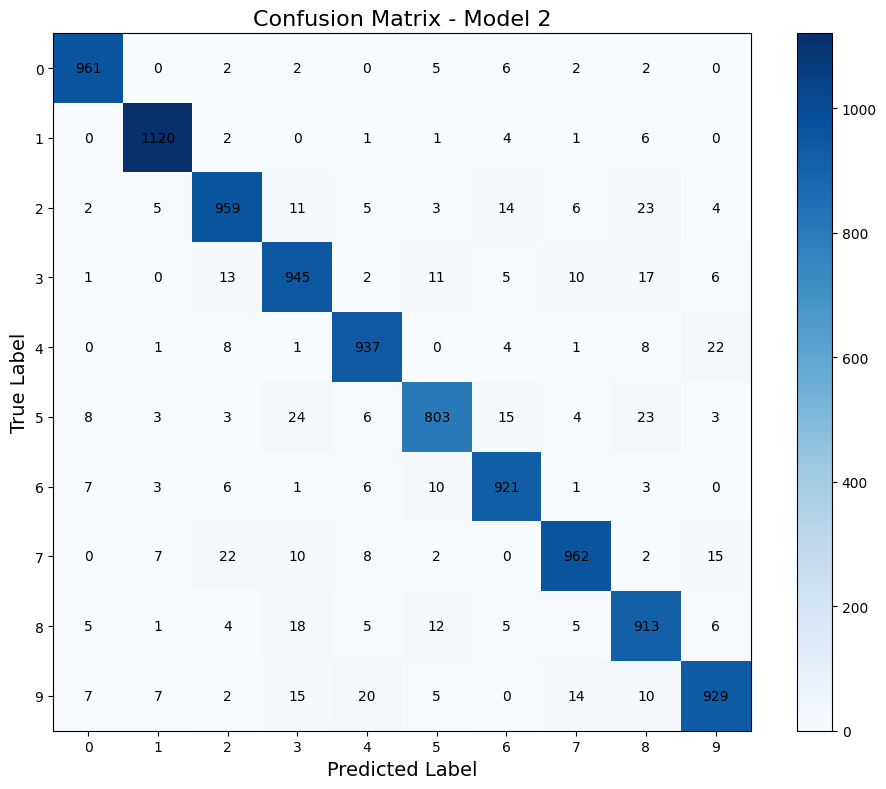

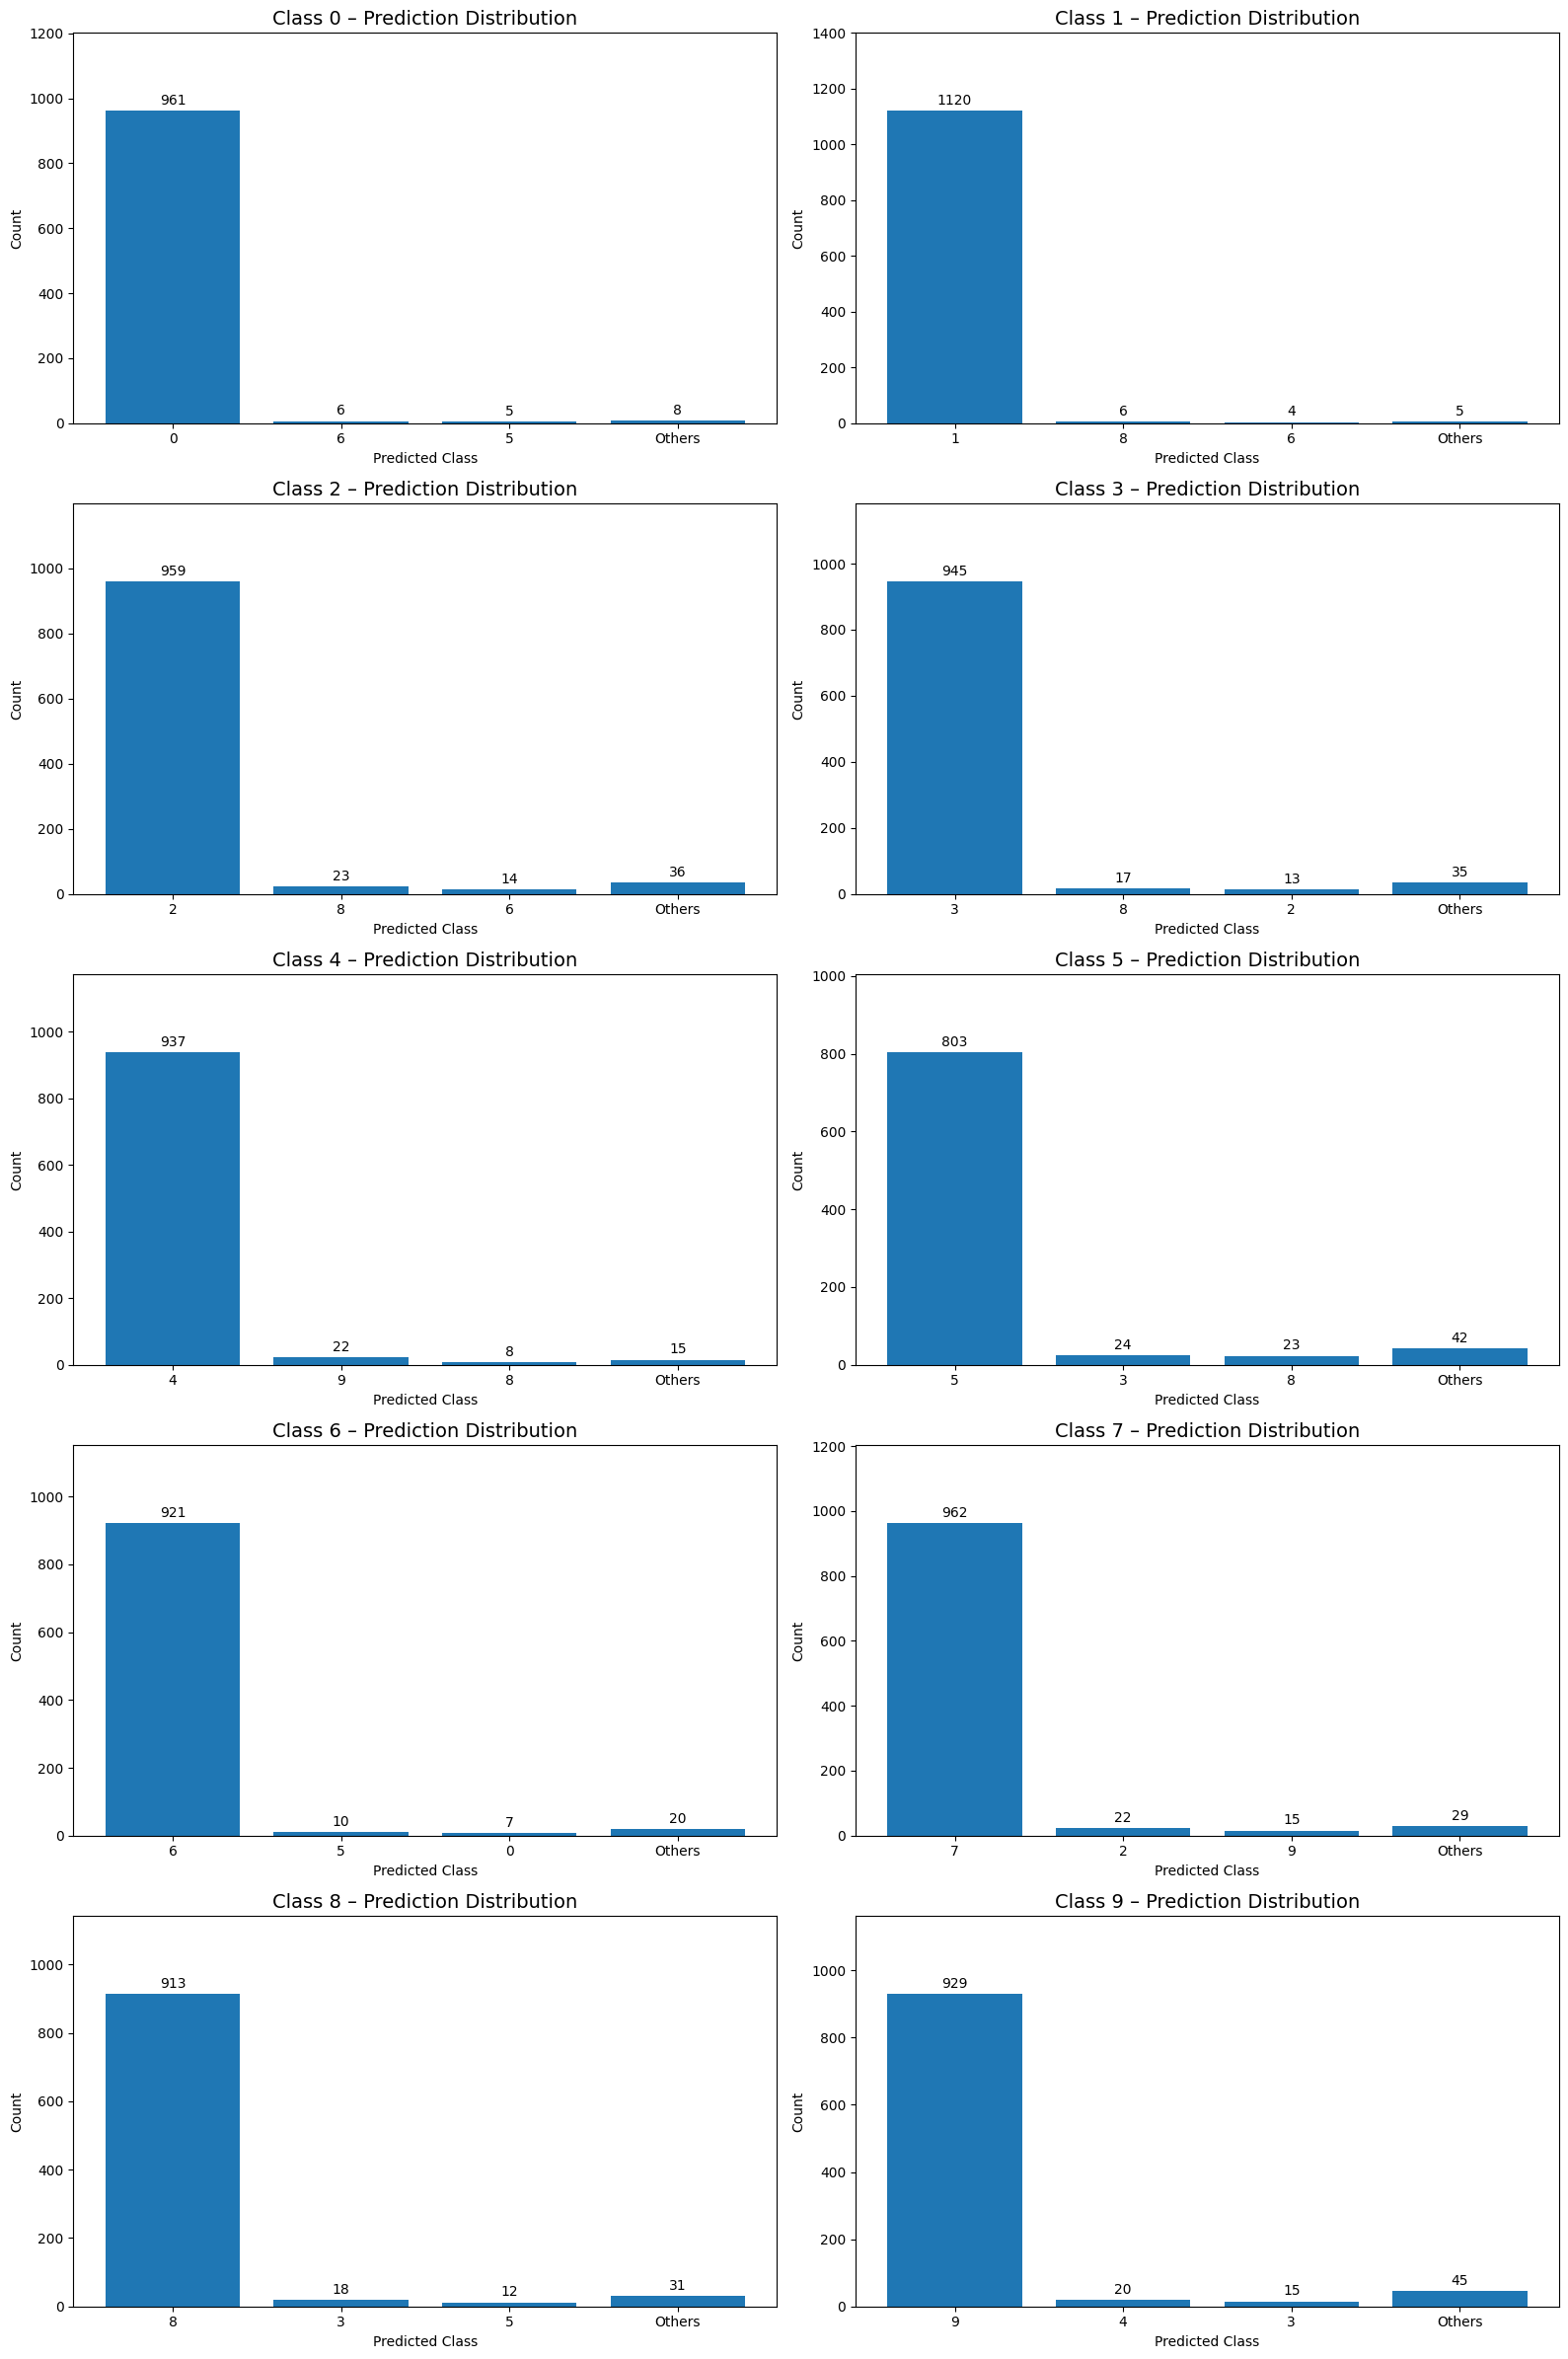

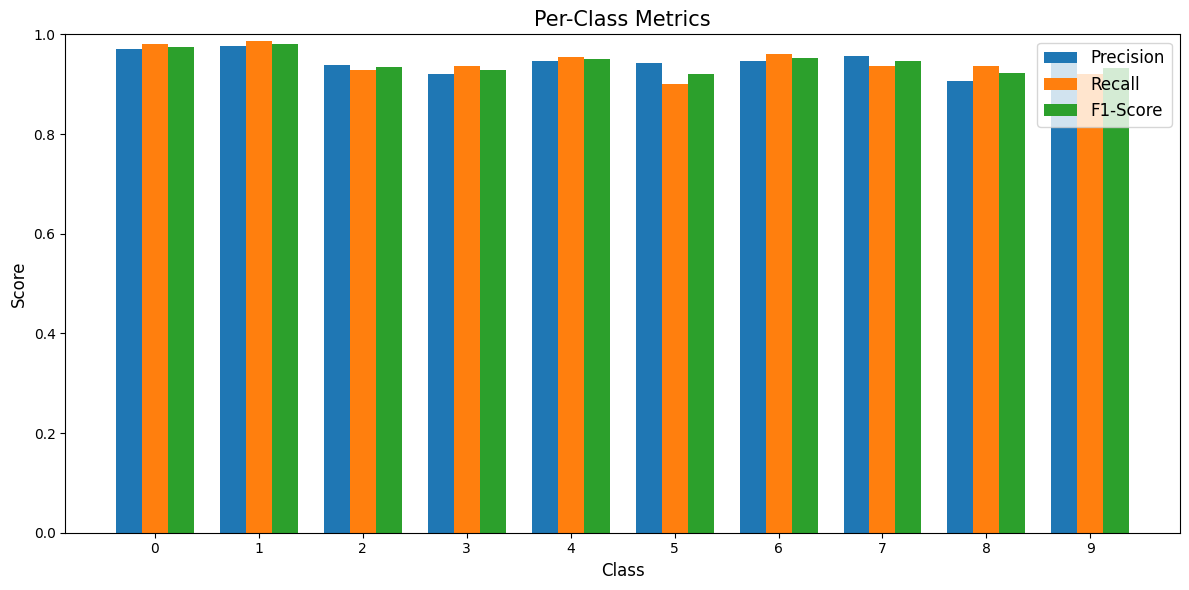

In [213]:
# Metrics
acc = compute_accuracy(y_test_2, predictions)
conf_matrix = compute_confusion_matrix(y_test_2, predictions, num_classes=10)
metrics = compute_classification_metrics(conf_matrix)

# Print accuracy
print(f"Test Accuracy: {acc * 100:.2f}%")

# Confusion matrix visualization
plot_confusion_matrix(conf_matrix, title="Confusion Matrix - Model 2")
plot_confusion_insights(conf_matrix)

# Per-class metric visualization
plot_class_metrics(metrics)


### 8.3 Function 3

*Set-up*

60000 28 28
10000 28 28
10000 28 28


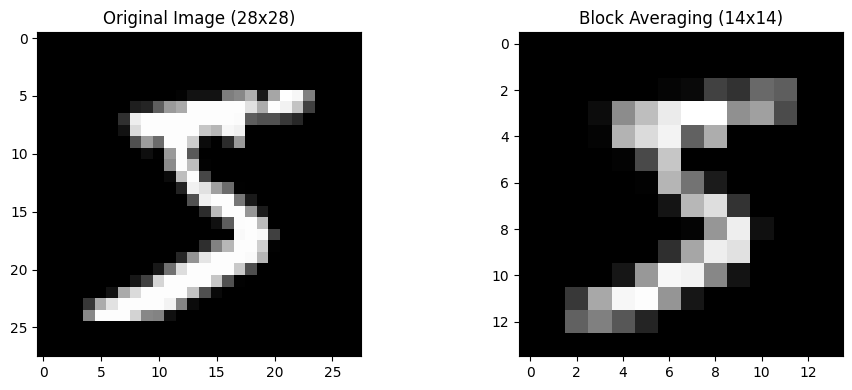

Train shape: (60000, 196), Labels: (60000,)


In [214]:
X_train_3, y_train_3, X_test_3, y_test_3 = function3(X_train, y_train, X_test, y_test)

print(f"Train shape: {X_train_3.shape}, Labels: {y_train_3.shape}")

*Train*

In [215]:
model3 = SoftmaxRegression(
    num_classes=10,
    lr=0.1,
    num_epochs=50,
    batch_size=128
)

print("\nTraining:")
model3.fit(X_train_3, y_train_3)


Training:
Epoch 1/50 - loss=0.9418 - train_acc=0.8644
Epoch 11/50 - loss=0.3448 - train_acc=0.9043
Epoch 11/50 - loss=0.3448 - train_acc=0.9043
Epoch 21/50 - loss=0.3179 - train_acc=0.9110
Epoch 21/50 - loss=0.3179 - train_acc=0.9110
Epoch 31/50 - loss=0.3062 - train_acc=0.9140
Epoch 31/50 - loss=0.3062 - train_acc=0.9140
Epoch 41/50 - loss=0.2990 - train_acc=0.9152
Epoch 41/50 - loss=0.2990 - train_acc=0.9152


*Test*

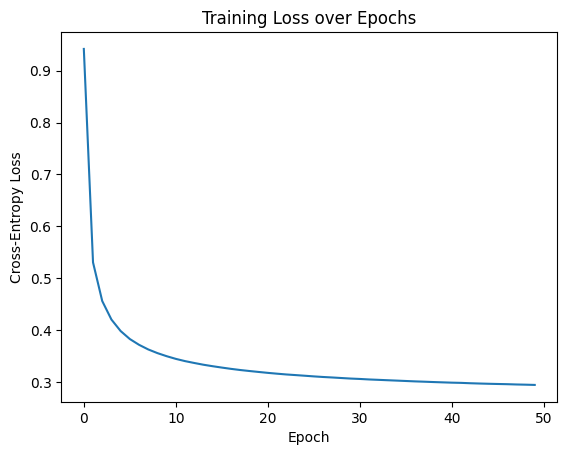

In [216]:
# Predict
predictions = model3.predict(X_test_3)

# Training loss plot
plt.plot(model3.history['loss'])
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.show()

*Visualize and report results*

Test Accuracy: 91.93%


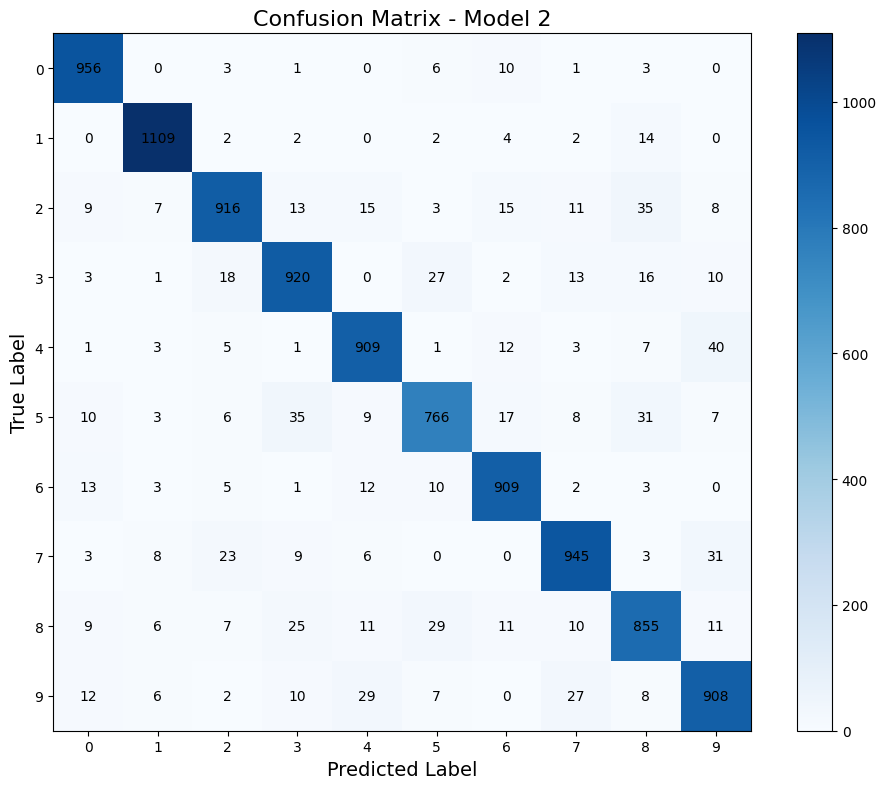

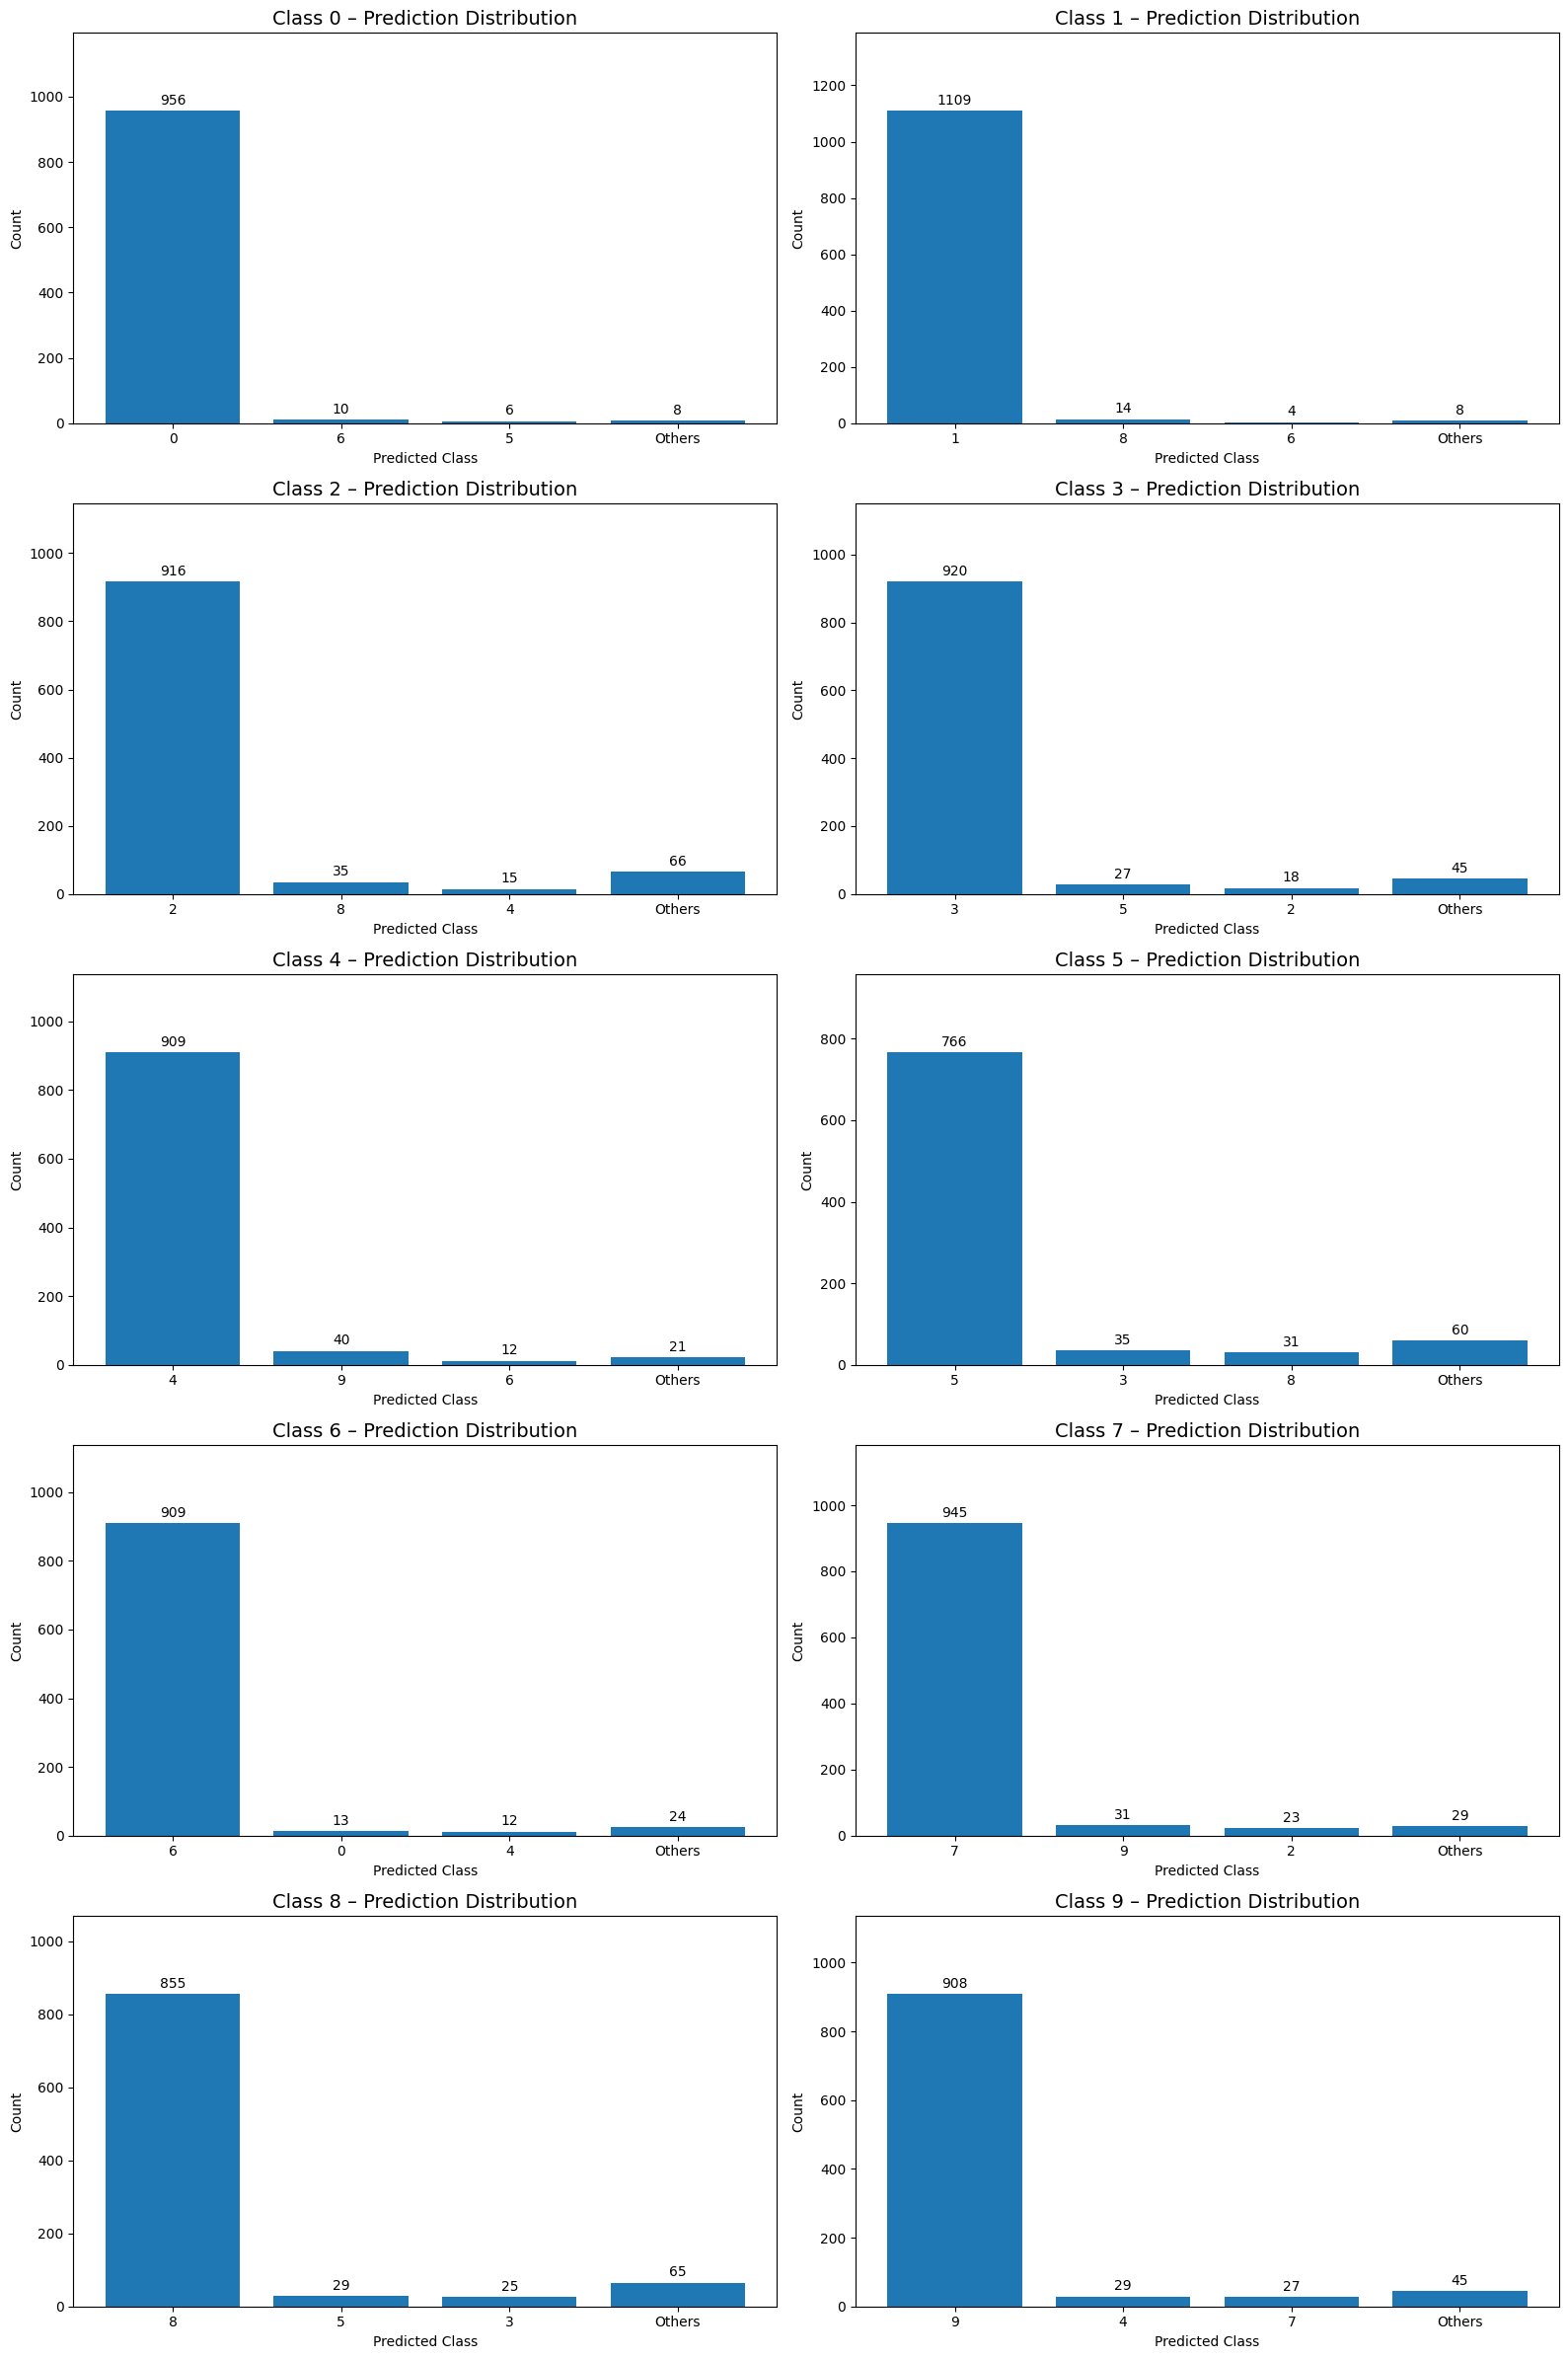

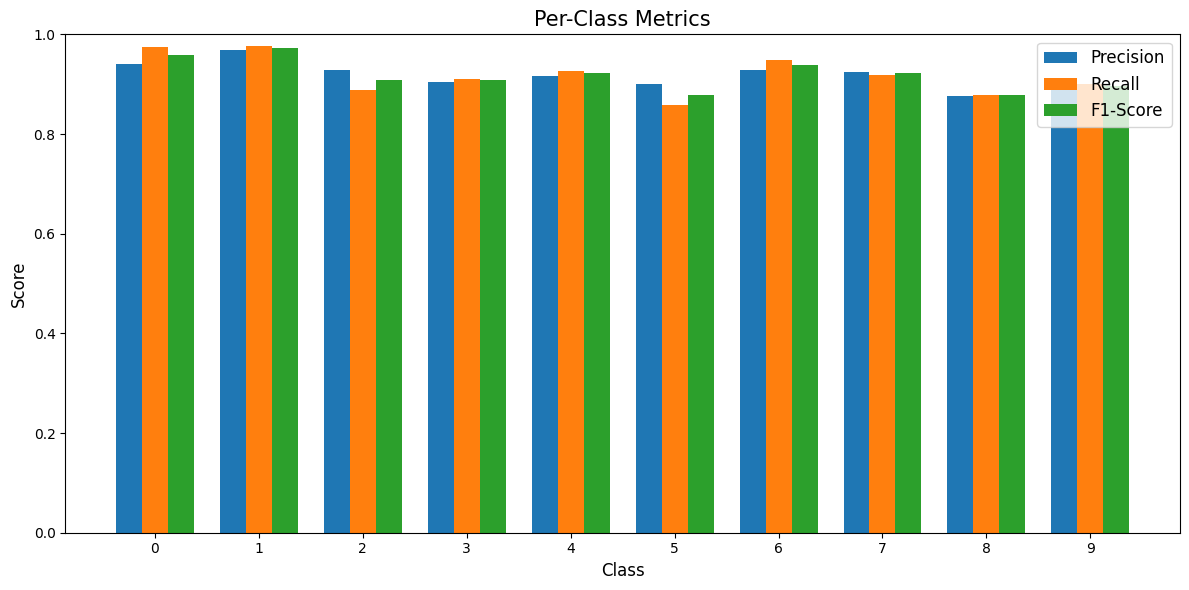

In [217]:
# Metrics
acc = compute_accuracy(y_test_3, predictions)
conf_matrix = compute_confusion_matrix(y_test_3, predictions, num_classes=10)
metrics = compute_classification_metrics(conf_matrix)

# Print accuracy
print(f"Test Accuracy: {acc * 100:.2f}%")

# Confusion matrix visualization
plot_confusion_matrix(conf_matrix, title="Confusion Matrix - Model 2")
plot_confusion_insights(conf_matrix)

# Per-class metric visualization
plot_class_metrics(metrics)


In [ ]:
# Lưu model

# 1. Model Pixel (Function 1)
np.savez('model_function1.npz', W=model1.W, b=model1.b)

# 2. Model Sobel (Function 2)
np.savez('model_function2.npz', W=model2.W, b=model2.b)

# 3. Model Block Average (Function 3)
# Giả sử biến model này là 'model3' như trong notebook
np.savez('model_function3.npz', W=model3.W, b=model3.b)
